# -- Objetivo do problema
    
    --1.0. Previsão do primeiro destino que um novo usuário irá escolher.
    
    --Por que?
        --Quak tipo de modelo de negócio do Airbnb
            --Marketplace( Conecta pessoas que oferecem acamodação, com pessoas que estão procurando acomodação )
            --Oferta ( pessoas oferecendo acomodação )
                -- Tamanho do portfolio
                -- Diversidade/densidade de portfolio.
                -- Preço Médio
                
            -- Demanda ( pessoas procurando acomodação )
                -- Numero de Usuários
                -- LTV ( Lifetime Value )
                -- CAC ( Client acquisition cost )
                
            -- Gross Revenue = (phi*Numero cliente) - CAC
                
            -- Demanda ( pessoas procurando acomodação )
            
--Proposta da solução
  - Modelo de previsão do primeiro destino de um novo usuário.
  - 1.0. Predições e salvar em uma tabela do banco de dados.
  - 2.0. API
        - Input: usuário e suas caracteristicas
        - output: usuario e suas caracteristicas com a coluna prediction

# 0.0. Imports 

In [1]:
import random

import pandas  as pd 
import numpy   as np 
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing   import OneHotEncoder
from sklearn.metrics         import classification_report, accuracy_score, balanced_accuracy_score, cohen_kappa_score
from scikitplot.metrics      import plot_confusion_matrix

from scipy.stats import skewnorm

from keras import models
from keras import layers

## 0.1. Helper Functions 

In [2]:
def numeric_statistics( df ):
    
    dic = {
        "type": df.dtypes.values,
        "Unique_Values": df.nunique().values,
        "Mean": df.mean(),
        "Median": df.median(),
        "Std": df.std(),
        "Min": df.min(),
        "Max": df.max(),
        "Range": df.max() - df.min(),
        "Skew": df.skew(),
        "Kurtosis": df.kurtosis()
    }
    
    return pd.DataFrame( dic, index=df.columns )

# 1.0. Data Description

In [3]:
df_raw = pd.read_csv( 'data/train_users_2.csv', low_memory=True )

df_sessions = pd.read_csv( 'data/sessions.csv', low_memory=True )

In [4]:
df_raw.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [5]:
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


## 1.1. Data Dimension  

In [6]:
print(f'Number of Rows: {df_raw.shape[0]}') 
print(f'Number of Columns: {df_raw.shape[1]}') 

Number of Rows: 213451
Number of Columns: 16


In [7]:
print(f'Number of Rows: {df_sessions.shape[0]}') 
print(f'Number of Columns: {df_sessions.shape[1]}') 

Number of Rows: 10567737
Number of Columns: 6


## 1.2. Data types 

In [8]:
df_raw.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [9]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3. Check NA 

In [10]:
df_raw.isnull().sum() / len(df_raw)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [11]:
df_sessions.isnull().sum() / len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.4. Description Analysis 

In [12]:
num_attributes = df_raw.select_dtypes( include=['int64','float64'] )
cat_attributes = df_raw.select_dtypes( include='object')

num_attributes_sessions = df_raw.select_dtypes( include=['int64','float64'] )
cat_attributes_sessions = df_raw.select_dtypes( include='object' )

In [13]:
numeric_statistics( num_attributes )

,type,Unique_Values,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
timestamp_first_active,int64,213451,2.013085e+13,2.013091e+13,9.253717e+09,2.009032e+13,2.014063e+13,5.031119e+10,-0.861578,0.355882
age,float64,127,4.966834e+01,3.400000e+01,1.556666e+02,1.000000e+00,2.014000e+03,2.013000e+03,12.422586,153.568929
signup_flow,int64,17,3.267387e+00,0.000000e+00,7.637707e+00,0.000000e+00,2.500000e+01,2.500000e+01,2.234366,3.324444


In [14]:
numeric_statistics( num_attributes_sessions )

,type,Unique_Values,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
timestamp_first_active,int64,213451,2.013085e+13,2.013091e+13,9.253717e+09,2.009032e+13,2.014063e+13,5.031119e+10,-0.861578,0.355882
age,float64,127,4.966834e+01,3.400000e+01,1.556666e+02,1.000000e+00,2.014000e+03,2.013000e+03,12.422586,153.568929
signup_flow,int64,17,3.267387e+00,0.000000e+00,7.637707e+00,0.000000e+00,2.500000e+01,2.500000e+01,2.234366,3.324444


# 2.0. Feature Engineering

In [30]:
df2 = df_raw.copy()

## 2.1. FillNA


## Costumers
If the customer didn't have a country destination, they didn't book an apartment to travel to, my solution to this variable is going to be to exchange the NA values for the max date from a first booking. 

## Age
for this variable I decided to fill the null values with a distribution with the same patterns as the variable age.

In [31]:
# date_first_booking
aux = df2[df2['date_first_booking'].isna()]

aux['country_destination'].value_counts( normalize=True )

NDF    1.0
Name: country_destination, dtype: float64

NDF      0.768428
US       0.156529
other    0.028617
FR       0.014888
IT       0.009081
GB       0.006251
ES       0.006171
CA       0.003989
DE       0.002387
NL       0.001818
AU       0.001171
PT       0.000671
Name: country_destination, dtype: float64 


Skew: 0.820838375560214
std: 9.99858442690581
mean: 35.45384731341284


C:\Users\Marcos\Projects\airbnb_prediction\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


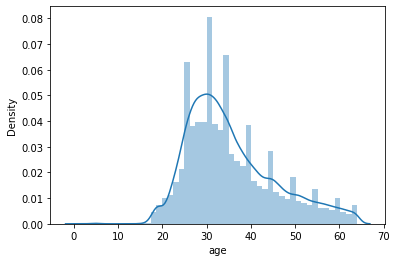

In [33]:
# age
aux = df2[df2['age'].isna()]
print( aux['country_destination'].value_counts( normalize=True ), '\n\n')

skew = df2[df2['age']<65]['age'].skew()
print(f'Skew: {skew}')

std = df2[df2['age']<65]['age'].std()
print(f'std: {std}')

mean = df2[df2['age']<65]['age'].mean()
print(f'mean: {mean}')

sns.distplot( df2[df2['age'] < 65]['age'] );

In [34]:
# date_first_booking
date_first_booking_max = pd.to_datetime( df2['date_first_booking'] ).max().strftime( '%Y-%m-%d' )
df2['date_first_booking'] = df2['date_first_booking'].fillna( date_first_booking_max )

# age
avg_age = df2['age'].mean().astype( 'int64' )
df2['age'] = df2['age'].apply(lambda x: skewnorm.rvs( skew, loc=mean, scale=std ).astype( 'int64' ) if pd.isna(x) else x )

# first_affiliate_tracked
df2 = df2[~df2['first_affiliate_tracked'].isna()]

## 2.2. Change Data Types 

In [35]:
aux_01 = df2.sample().T
aux_02 = df2.sample().dtypes

pd.concat( [aux_01,aux_02], axis=1 )

,116007,0
id,1zu9krpn9w,object
date_account_created,2013-10-11,object
timestamp_first_active,20131011070412,int64
date_first_booking,2015-06-29,object
gender,FEMALE,object
age,36.0,float64
signup_method,facebook,object
signup_flow,12,int64
language,en,object
affiliate_channel,api,object


In [36]:
# date_account_created
df2['date_account_created'] = pd.to_datetime( df2['date_account_created'] )

# timestamp_first_active
df2['timestamp_first_active'] = pd.to_datetime( df2['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date first_booking 
df2['date_first_booking'] = pd.to_datetime( df2['date_first_booking'] )  
                                           
# age 
df2['age'] = df2['age'].astype( 'int64' )

## 2.3. Check Blanced Data

In [15]:
df2['country_destination'].value_counts( normalize=True )

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

# 3.0. Data Filtering

In [16]:
df3 = df2.copy()

# 4.0. EDA

In [17]:
df4 = df3.copy()

# 5.0. Data Preparation 

In [18]:
df5 = df4.copy()

df5_dummys = pd.get_dummies( df5.drop( ['id','country_destination'], axis=1 ) )

df5 = pd.concat( [ df5[['id','country_destination']], df5_dummys], axis=1 )

# 6.0. Feature Selection

In [19]:
df5.columns

Index(['id', 'country_destination', 'date_account_created',
       'timestamp_first_active', 'date_first_booking', 'age', 'signup_flow',
       'gender_-unknown-', 'gender_FEMALE', 'gender_MALE',
       ...
       'first_browser_Safari', 'first_browser_SeaMonkey', 'first_browser_Silk',
       'first_browser_SiteKiosk', 'first_browser_SlimBrowser',
       'first_browser_Sogou Explorer', 'first_browser_Stainless',
       'first_browser_TenFourFox', 'first_browser_TheWorld Browser',
       'first_browser_Yandex.Browser'],
      dtype='object', length=117)

In [20]:
cols_drop = ['date_account_created','timestamp_first_active','date_first_booking']
df5 = df5.drop( cols_drop, axis=1 )

In [21]:
X = df5.drop( ['id','country_destination'], axis=1 )
y = df5['country_destination'].copy()

# 7.0. Machine Learning

In [22]:
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=32 )

## 7.1. Baseline model

In [23]:
index = df5['country_destination'].value_counts().index
values = df5['country_destination'].value_counts( normalize=True ).values

In [24]:
yhat_random = random.choices( population=index, weights=values, k=y_val.shape[0] )

In [25]:
# prediction prepare
y_val_random = y_val.to_numpy()

  model  Accuracy  BalancedAccuracy  KappaScore
0    NN  0.523212          0.092667    0.004504
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.02      0.01      0.01       214
          DE       0.02      0.02      0.02       170
          ES       0.02      0.02      0.02       345
          FR       0.06      0.06      0.06       710
          GB       0.05      0.05      0.05       344
          IT       0.02      0.02      0.02       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      0.71      0.71      9624
       other       0.12      0.11      0.11      1540

    accuracy                           0.52     13635
   macro avg       0.09      0.09      0.09     13635
weighted avg       0.52      0.52      0.52     13635



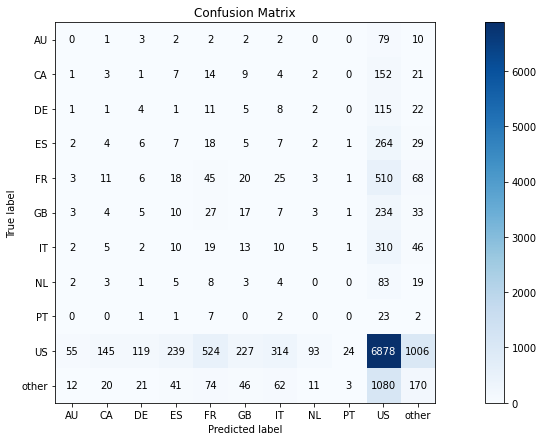

In [26]:
# balanced accuracy, accuracy, kappa score 
dic = {
    'model': 'NN',
    'Accuracy': accuracy_score( y_val_random, yhat_random ),
    'BalancedAccuracy': balanced_accuracy_score( y_val_random, yhat_random ),
    'KappaScore': cohen_kappa_score( y_val_random, yhat_random )
}
print( pd.DataFrame( dic, index=[0] ) )
print( classification_report( y_val_random, yhat_random ) )

# confusion matrix
plot_confusion_matrix(y_val_random, yhat_random, figsize=(18,7) );

## 7.2. NN 

In [27]:
on = OneHotEncoder()
y_train_nn = on.fit_transform( y_train.values.reshape(-1,1) ).toarray()

In [28]:
# model definition
model = models.Sequential()
model.add( layers.Dense( 128, input_dim=X_train.shape[1], activation='relu' ) )
model.add( layers.Dense( 11, activation='softmax' ) )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( X_train, y_train_nn, epochs=100, verbose=0 )

# 8.0. Model Performance 

In [29]:
# prediction
pred_nn = model.predict( X_val )

# invert prediction
yhat_nn =  on.inverse_transform( pred_nn )

# prediction prepare
y_val_nn = y_val.to_numpy()
yhat_nn = yhat_nn.reshape( 1,-1 )[0]

  model  Accuracy  BalancedAccuracy  KappaScore
0    NN  0.703044          0.091046    0.002663
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.00      0.00      0.00       170
          ES       0.00      0.00      0.00       345
          FR       0.00      0.00      0.00       710
          GB       0.00      0.00      0.00       344
          IT       0.00      0.00      0.00       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      1.00      0.83      9624
       other       0.21      0.01      0.01      1540

    accuracy                           0.70     13635
   macro avg       0.08      0.09      0.08     13635
weighted avg       0.52      0.70      0.58     13635



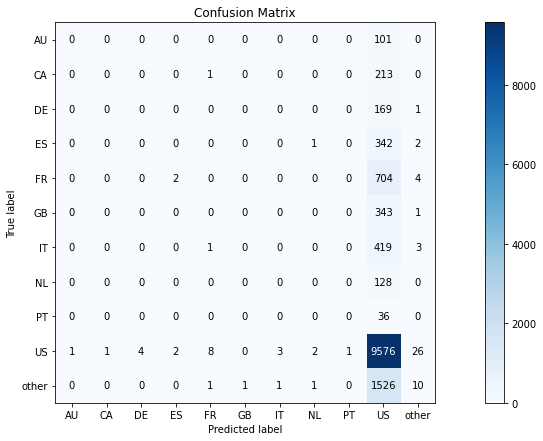

In [30]:
# balanced accuracy, accuracy, kappa score 
dic = {
    'model': 'NN',
    'Accuracy': accuracy_score( y_val_nn, yhat_nn ),
    'BalancedAccuracy': balanced_accuracy_score( y_val_nn, yhat_nn ),
    'KappaScore': cohen_kappa_score( y_val_nn, yhat_nn )
}
print( pd.DataFrame( dic, index=[0] ) )
print( classification_report( y_val_nn, yhat_nn ) )

# confusion matrix
plot_confusion_matrix(y_val_nn, yhat_nn, figsize=(18,7) );

## 8.1. Cross Validation 

In [31]:
# generate k-fold
num_folds = 5
kfold = StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1

for train_ix, val_ix in kfold.split( X_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    X_train_fold = X_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = X_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = models.Sequential()
    model.add( layers.Dense( 256, input_dim=X_train.shape[1], activation='relu' ) )
    model.add( layers.Dense( 11, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( X_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

print(f'Avg Balanced Accuracy: {np.mean( balanced_acc_list )} +/- {np.std( balanced_acc_list )}' )
print(f'Avg Kappa: {np.mean( kappa_acc_list )} +/- {np.std( kappa_acc_list )}' )

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5
Avg Balanced Accuracy: 0.09155718094644394 +/- 0.00022635929012134227
Avg Kappa: 0.002817943288701352 +/- 0.0017295300685959945
